In [1]:
import numpy as np

import torch
from torch import nn
import torch.optim as optim
from torch.utils.data import random_split
import torchvision
from torchvision import models
import torchvision.transforms as transforms
from torchsummary import summary
from fastai.vision.all import *

import matplotlib.pyplot as plt
from IPython import display

from my_models import VGG

In [2]:
in_channels = 3
out_channels = 10
device = "cuda:0"
net = VGG(in_channels = in_channels, 
            out_channels = out_channels,
            conv_blocks_out_size = [32,64,64,128,128],
            conv_blocks_amounts = [1,1,2,2,2],
            linear_layers_out_size = [200,200,out_channels])
net.to(device)

train_loss = nn.CrossEntropyLoss()

learning_rate = 1e-4
optimizer = optim.Adam(net.parameters(), lr=learning_rate)

batch_size = 10
epoch_num = 10

In [3]:
# summary(net, (3, 32, 32))

In [4]:
path = URLs.IMAGENETTE_160

In [5]:
def get_dls(path, size, batch_size, workers=None):
    source = untar_data(path)

    resize_ftm = Resize(size)
    dblock = DataBlock(blocks=(ImageBlock, CategoryBlock),
                       splitter=GrandparentSplitter(valid_name='val'),
                       get_items=get_image_files, get_y=parent_label,
                       item_tfms=[resize_ftm])
    return dblock.dataloaders(source, path=source, bs=batch_size)

In [6]:
dloaders = get_dls(path, 160, batch_size = batch_size)

In [7]:
trainloader = dloaders.train
trainloader = trainloader.new(shuffle=True)
valloader = dloaders.valid
valloader = valloader.new(shuffle=True)

In [8]:
def accuracy_and_loss(dataloader, net, device, criterion):
    current_loss = 0.0
    steps = 0
    total = 0
    correct = 0
    
    for data in dataloader:
        with torch.no_grad():
            inputs, labels = data

            outputs = net(inputs)
            _, predicted = torch.max(outputs.detach(), 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            loss = criterion(outputs, labels)
            current_loss += loss.cpu().numpy()
            steps += 1

    current_loss /= steps
    accuracy = correct / total
    return accuracy, current_loss

In [9]:
def show_plot(data_arrays, titles, xlabel, ylabels):
    fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(8,8))

    for plot_num, ax in enumerate(axs.flat):
        ax.plot(data_arrays[plot_num])
        ax.set_title(titles[plot_num])
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabels[plot_num])
        ax.grid(True)

    plt.tight_layout()
    plt.show()

In [10]:
def train(net, optimizer, criterion, epoch_num, trainloader, valloader, device):
    val_loss_history = []
    val_accuracy_history = []
    train_accuracy_history = []
    train_loss_history = []
    
    for epoch in range(epoch_num):  # loop over the dataset multiple times
        for data in trainloader:
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
        # Train accuracy
        current_train_accuracy, current_train_loss = accuracy_and_loss(trainloader, net, device, criterion)     
        train_accuracy_history.append(current_train_accuracy)
        train_loss_history.append(current_train_loss)

        # Validation accuracy and loss
        current_val_accuracy, current_val_loss = accuracy_and_loss(valloader, net, device, criterion)     
        val_loss_history.append(current_val_loss)
        val_accuracy_history.append(current_val_accuracy)
        
        # visulization:
        display.clear_output(wait=True)

        show_plot(data_arrays=[train_loss_history, train_accuracy_history, val_loss_history, val_accuracy_history],
                  titles=["Train loss", "Train accuracy", "Validation loss", "Validation accuracy"], 
                  xlabel="epoch number", 
                  ylabels=["loss", "accuracy"]*2)

        
        
        
        print('Current train loss: %f' % current_train_loss)
        print('Current train accuracy: %f' % current_train_accuracy)

        print('Current validation loss: %f' % current_val_loss)
        print('Current validation accuracy: %f' % current_val_accuracy)
    return net

In [11]:
def test_metrics(net, device, testloader, out_channels):    
    # accuracy
    # confusion matrix
    # f1, precision / recall
    
    true_positive = 0
    false_positive = 0
    false_negative = 0
    
    correct = 0
    total = 0
    confusion_matrix_counted = torch.zeros(out_channels, out_channels)

    with torch.no_grad():
        for data in testloader:
            images, labels = data

            outputs = net(images)
            _, predicted = torch.max(outputs.detach(), 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item() # true_positive + true_negative

            true_positive += ((predicted == labels) == 1).sum().item()            
            false_positive += ((predicted == 1) != labels).sum().item()
            false_negative += ((predicted == 0) != labels).sum().item()

            for label, prediction in zip(labels, predicted):
                confusion_matrix_counted[label, prediction] += 1
                
    confusion_matrix_counted /= confusion_matrix_counted.sum(axis=1)
    accuracy = correct / total
    
    precision = true_positive/(true_positive + false_positive)
    recall = true_positive/(true_positive + false_negative)
    f1 = 2*precision*recall/(precision+recall)
   
    return accuracy, confusion_matrix_counted, precision, recall, f1

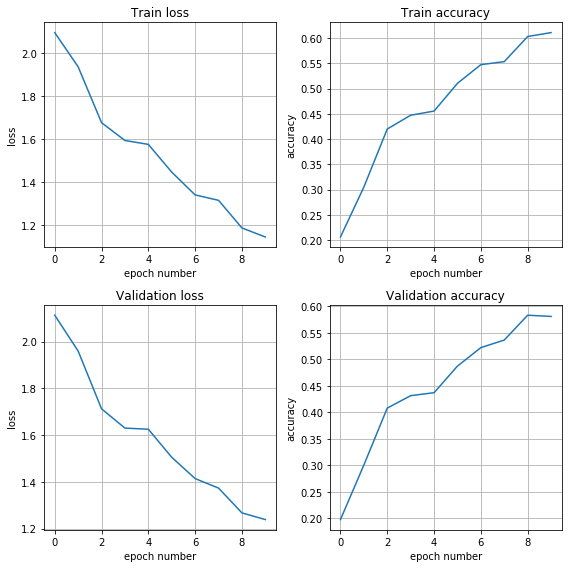

Current train loss: 1.143084
Current train accuracy: 0.610782
Current validation loss: 1.238743
Current validation accuracy: 0.580892
CPU times: user 2min 46s, sys: 1min 27s, total: 4min 13s
Wall time: 3min 35s


In [12]:
%%time
net = train(net, optimizer, train_loss, epoch_num, trainloader, valloader, device)

In [13]:
accuracy, conf_matrix, precision, recall, f1 = test_metrics(net, device, valloader, out_channels) # здесь пока так, но надо переделать

print("Test accuracy: ", accuracy)
print("Test precision: ", precision)
print("Test recall: ", recall)
print("Test f-measure: ", f1)

Test accuracy:  0.5808917197452229
Test precision:  0.4103671706263499
Test recall:  0.37395440380515005
Test f-measure:  0.39131554106238736


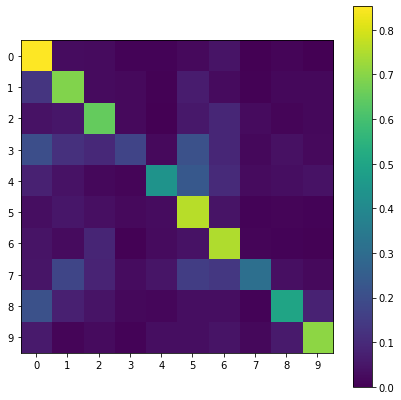

In [14]:
plt.figure(figsize=(7, 7))

plt.imshow(conf_matrix)
plt.xticks(range(conf_matrix.shape[0]))
plt.yticks(range(conf_matrix.shape[0]))
plt.colorbar()
plt.show()

In [15]:
data, labels = valloader.one_batch()

In [16]:
outputs = net(data)
_, predicted = torch.max(outputs.detach(), 1)

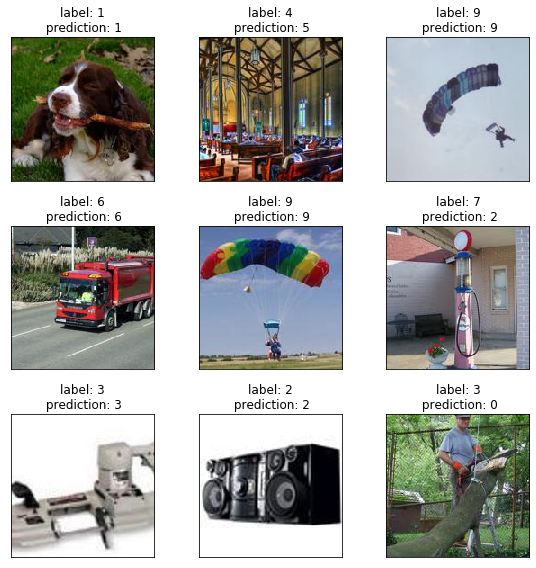

In [17]:
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(8,8), subplot_kw={'xticks': [], 'yticks': []})

for picture_num, ax in enumerate(axs.flat):
    ax.imshow(data[picture_num].cpu().permute(1, 2, 0))
    ax.set_title("label: {}\n prediction: {}".format(labels[picture_num], 
                                                     predicted[picture_num]))

plt.tight_layout()
plt.show()